# TF-IDF notebook


# Cleaning data 
In order to run tf-idf, we need to do two things:
- remove punctuation from text
- combine recognizeable place names 

In [14]:
# imports
# Load the dataset
from src.settings import FOLDER_ARTICLES, DATA_FOLDER
from concurrent.futures import ProcessPoolExecutor
import json
import string
import re
from flashtext.keyword import KeywordProcessor
import snowballstemmer
from concurrent.futures import ProcessPoolExecutor as Executor
from pathlib import Path
from collections import Counter
import copy
import json
from src.settings import DATA_FOLDER

import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
import orjson
import matplotlib.pyplot as plt
import numpy as np


CLEANED_DATA_FOLDER = DATA_FOLDER / "cleaned_json"
CLEANED_DATA_FOLDER.mkdir(exist_ok=True)
TOKENIZED_DATA_FOLDER = DATA_FOLDER / "tokenized_json"
TOKENIZED_DATA_FOLDER.mkdir(exist_ok=True)

In [ ]:
json_files = list(FOLDER_ARTICLES.glob("*.json"))

cleaned_articles = []
counter = 0
total_files = len(json_files)
from tfidf_imports import clean_text  # must be imported from another file in order for multiprocessing to work

with ProcessPoolExecutor() as executor:
    for json_file, file_result in zip(json_files, executor.map(clean_text, json_files)):
        cleaned_articles.append(file_result)
        counter += 1
        print(f"Processing file {counter}/{total_files}", end="\r")

        output_file = CLEANED_DATA_FOLDER / json_file.name
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(file_result, f, ensure_ascii=False, indent=4)



KeyboardInterrupt: 

# Tokenize place names
We have a list of place names which occasionally have spaces and such. We need to process it such that you capitalize them, and concatenate them. 

In [19]:
COLONIAL_PLACES_UNPROCESSED = ['darma pass', 'tawang', 'dirang', 'tulung la', 'nyuri', 'bomdi la', 'lhau', 'pangchen', 'lumpo', 'chigup la', 'jang', 'foot hills camp', 'se la', 'jamiri', 
                   'lha la', 'balipara', 'kashong la', 'sarai amanat khan', 'patiala', 'jalandhar', 'fatehgarh', 'bir kishansingh', 'hayatnagar', 'jaunpur', 'cossimbazar', 'bhagalpur', 
                   'sebu la', 'baramula', 'lachen', 'tezpur', 'bomdila', 'quilon', 'essau', 'benin-city', 'pategi', 'khajuraho', 'calliena', 'tangtse', 'champai', 'dilkawn', 'haulawng', 
                   'hlaikhan', 'hydel rest house', 'kacharian forest rest house', 'lumtui', 'mogilipenta', 'nagar hole', 'neokka rest house', 'pahara puri rest house', 'patainag rest house', 
                   'pili ki khan', 'sita bani', 'tapuraki khan', 'agham', 'chagra', 'chalan chumik', 'chartse', 'chhong jangal', 'chongdongmale', 'chung tung', 'dachung yogma', 'dakbajan', 
                   'dangangongmale', 'dangyailak', 'daulat beg oldi', 'debring', 'fariabad', 'gangrale', 'gapshan', 'goma tharu', 'hurling', 'kaksang', 'kanatal', 'karale', 'kataklik', 'katlang chenmo', 
                   'kenlung', 'khala', 'khargok fort', 'kharlung', 'khiangshisa', 'khurmafu', 'khurna sumdo', 'lakong', 'lama guru', 'lapurba', 'lashitanga', 'lekaru', 'lichu', 'lingti', 'loma', 'lungkung', 
                   'lungnakle', 'lungturma', 'luntunnu', 'mankhang', 'karur', 'miksadiu', 'muldem', 'mundio', 'murshun', 'nelda serbonle', 'niri', 'niri sumdo', 'numah', 'nyamur', 'orarucha', 'pachatang', 
                   'pamzal', 'pang', 'pangot', 'patseo', 'peldo', 'pololung', 'pungiado', 'purang sumdo', 'puti runi', 'rachogba', 'ramjak', 'rimdi', 'sangcha talla', 'sangtha', 'saser brangsa', 
                   'shokpa kunglang', 'shurok sumdo', 'spanggur', 'sumdo', 'sumdo (2)', 'sumdole', 'sumdole (2)', 'surai thota', 'sutak', 'tangoleb', 'tangyar', 'tarakokpole', 'topo koma', 'trakkur', 
                   'tsakshang', 'tsogstsolu', 'tut yailak', 'umdung', 'umlung', 'yaglung', 'yahle', 'yargulak', 'zingzingbar', 'katra', 'karvan', 'karvan', 'katra (2)', 'katra (3)', 'katra (4)', 'katra (5)',
                'katra (6)', 'khatra (6)', 'kodungallur', 'paithan', 'lothal', 'sopara', 'kalyan', 'simylla', 'pondicherry', 'tamluk', 'kaverippattanam', 'korkai', 'sholapur', 'kargil', 'bourem', 'bahadurpur', 
                    'shahabad', 'borghat pass', 'nanaghat', 'thal ghat', 'mathura', 'mathura (2)', 'srinagar', 'ujjain', 'yola', 'bauchi', 'zaria', 'katsina', 'sokoto', 'gwandu', 'birnin-kebbi', 'salaga', 
                    'waypoint-2375', 'cuttack', 'mangalore', 'chennai', 'kolkata', 'sasaram', 'darjiling', 'chekawn', 'gongrale', 'hodal', 'allahabad', 'patna', 'agra', 'hyderabad (2)', 'jaipur', 'ahmadabad', 
                    'ahmadnagar', 'ajmer', 'vadodara', 'beawar', 'gogunda', 'pali', 'ambala', 'pir panjal pass', 'handia', 'aurangabad', 'baleshwar', 'bayana', 'bijapur', 'varanasi', 'burhanpur', 'khambhat', 
                    'chopda', 'delhi', 'dhaulpur', 'gwalior', 'jodhpur', 'karnal', 'kolaras', 'ludhiana', 'mandu', 'mehsana', 'nandurbar', 'panipat', 'pipar', 'rajmahal', 'sehore', 'fatehpur sikri', 'sirhind', 
                    'sironj', 'surat', 'udaipur', 'narwar', 'sonipat', 'asirgarh', 'sirohi', 'shahabad', 'kano', 'abuja', 'acadia', 'accra', 'acton', 'adobe walls', 'agra', 'agra', 'ahmedabad', 'ajmer', 'ajmer', 
                    'akbarpur', 'alabama', 'alabama', 'alaska', 'alaska range', 'alberta', 'aleutian islands', 'alexandria', 'allahabad', 'allahabad', 'alwar', 'amritsar', 'andaman islands', 'anjengo', 
                    'appalachian mountains', 'arapaho', 'arctic ocean', 'arizona', 'arkansas', 'arkansas', 'arkat', 'asante', 'assam', 'atlan', 'athabasca', 'atlanta', 'austin', 'awadh', 'axim', 'ayodhya', 
                    'baffin island', 'bahamas', 'bajwara', 'bangala', 'balasore', 'baltimore', 'banks island', 'barar', 'barbados', 'baroda', 'baton rouge', 'bauchi', 'bayana', 'beas', 'belize', 'bemis heights', 'benares', 
                    'bengal', 'bennington', 'benue', 'berbice', 'bhatkal', 'bhopal', 'bhopal', 'bida', 'bidar', 'bidar', 'big cypress swamp', 'big meadows', 'bihar', 'bijapur', 'biloxi', 'bimlipatam', 'bird creek', 'blackstock', 
                    'boise', 'bono', 'boston', 'brahmaputra', 'brazos', 'british columbia', 'british guiana', 'british honduras', 'british north borneo', 'brooks range', 'burhanpur', 'cachar', 'cahokia', 'calabar', 'calcutta', 'calgary', 
                    'calicut', 'california', 'cambay', 'camden', 'canada', 'canyon de chelly', 'cape breton island', 'carrier', 'carson city', 'cascades', 'cawnpore', 'cayes', 'central india agency', 'central provinces', 'ceylon', 'chambal', 
                     'chandernagore', 'charlotte', 'charlottesville', 'chaul', 'chicago', 'chiaha', 'chinsura', 'chitimacha', 'chitor', 'cincinnati', 'cleveland', 'coast mountains', 'colombo', 'colorado', 'colorado', 'connecticut', 'connecticut', 'coondapoor', 
                     'coorg', 'coromandel coast', 'cossimbazar', 'costa rica', 'cranganur', 'culver city', 'cumberland river', 'cuttack', 'dallas', 'daman', 'deccan', 'deccan states', 'delaware', 'delaware', 'delhi', 'demerara', 'denver', 
                     'des moines', 'detroit', 'dharangaon', 'dikwa', 'dominica', 'dove creek', 'eastmain', 'eastern ghats', 'edmonton', 'el paso', 'ellesmere island', 'ellora', 'elmina', 'erie', 'erie, lake', 'etawah', 'fallen timbers', 'flathead', 
                     'florida', 'fort beauséjour', 'fort chambly', 'fort dearborn', 'fort detroit', 'fort duquesne', 'fort frontenac', 'fort kearney', 'fort liberté', 'fort malden', 'fort mellon', 'fort mims', 'fort necessity', 'fort niagara', 'fort orange', 
                     'fort oswego', 'fort stanwix', 'fort ticonderoga', 'fort william', 'fowltown', 'frankfort', 'frederiksnagar', "freeman's farm", 'fyzabad', 'ganges', 'garhgaon', 'georgia', 'georgian bay', 'ghaghara', 'gobir', 'godavari', 'goliad massacre',
                       'golkonda', 'golkonda', 'gombe', 'gonave', 'gooty', 'granada', 'grand canyon', 'great bear lake', 'great plains', 'great salt lake', 'great slave lake', 'guiana', 'gujarat', 'gulbarga', 'gwalior', 'gwandu', 'hadejia', 'haiti', 'halifax', 
                       'harrisburg', 'harrodsborough', 'hartford', 'havasupai', 'hawaiian islands', 'honavar', 'honduras', 'honolulu', 'hooghly', 'houma', 'houston', 'howrah', 'hualapai', 'hubli', 'huron, lake', 'hyderabad', 'hyderabad', 'idaho', 'ijebu ode', 
                'illichpur', 'illinois', 'illinois', 'ilorin', 'imphal', 'india', 'indiana', 'indianapolis', 'indore', 'iowa', 'jacksonville', 'jaipur', 'jalalpur', 'jamaica', 'jammu and kashmir', 'jamshedpur', 'jefferson city', 'jharkhand', 'jicarilla apache',
                'johore', 'junagarh', 'junnar', 'kaabu', 'kalhat', 'kanara', 'kandy', 'kano', 'kano', 'kansas', 'kansas city', 'karankawa', 'karikal', 'kashmir', 'kaskaskia', 'katagum', 'katak', 'kathiawar', 'katsina', 'katsina', 'kaveri', 'kayankulam', 'kedah', 
                 'kentucky', 'khairabad', 'khandesh', 'khurja', 'kiet siel', "king's mountain", 'kingston', 'knoxville', 'kolhapur', 'konkan', 'krishna', 'kuala lumpur', 'kukawa', 'kumaun', 'labrador', 'lakhawar', 'lansing', 'laurentian highlands', 'lipan', 
                 'little rock', 'long island', 'los angeles', 'louisbourg', 'louisiana', 'louisville', 'lucknow', 'luni', 'mackenzie', 'mackenzie mountains', 'madras', 'madura', 'madurai', 'mahanadi', 'mahe', 'maheshwar', 'maine', 'malabar coast', 'malacca', 
                 'manoa', 'malaya', 'malaysia', 'malwa', 'managua', 'mangalore', 'mangalur', 'manipur', 'manitoba', 'maryland', 'massachusetts', 'masulipatam', 'maui', 'mescalero', 'mescalero apache', 'miami', 'michigan', 'michigan, lake', 'milwaukee', 'minnesota',                   
                 'mississippi', 'mississippi', 'missouri', 'missouri', 'mobile', 'mojave', 'molokai', 'montana', 'montreal', 'mosquito coast', 'mubi', 'murshidabad', 'mysore', 'mysore', 'nagpur', 'nashville', 'navajo', 'nebraska', 'nefertare', 'negombo', 'nevada', 
                 'new amsterdam', 'new brunswick', 'new calabar', 'new england', 'new hampshire', 'new haven', 'new jersey', 'new mexico', 'new orleans', 'new ulm', 'new york', 'new york', 'newfoundland', 'newfoundland', 'niagara', 'nicaragua', 'niger', 'ningi', 
                 "nizam's dominions", 'nizampatam', 'north carolina', 'north dakota', 'northwest territories', 'nova scotia', 'oahu', 'ohio', 'ohio', 'ojibwa', 'oklahoma', 'ontario', 'ontario, lake', 'orchha', 'oregon', 'orisa', 'orissa', 'ottawa', 'ottawa', 'ottawa', 
                'oudh', 'paiute', 'panamá', 'panipat', 'passamaquoddy', 'pedee', 'pee dee', 'penang', 'pennsylvania', 'pensacola', 'pensacola', 'pequot', 'perak', 'philadelphia', 'plassey', 'poona', 'pondicherry', 'port-au-prince', 'portobelo', 'prince edward island',
                'puttalam', 'quapaw', 'quebec', 'quebec', 'quilon', 'rajputana', 'raleigh', 'rampur', 'regina', 'reindeer lake', 'rhode island', 'roanoke', 'rohilkhand', 'rupert house', 'sabarmati', 'sacramento', 'sadras', 'salt lake city', 'samana', 'san antonio', 
                'san diego', 'san francisco', 'san josé', 'santa fe trail', 'sarawak', 'sarkhej', 'saskatchewan', 'saskatchewan', 'saskatoon', 'satpura range', 'savanur', 'seattle', 'serampore', 'seringapatam', 'shillong', 'sholapur', 'shorapur', 'shreveport',
                'sindhia', 'sira', 'sironj', 'slave', 'soccorra', 'sokoto', 'sokoto', 'south carolina', 'south dakota', 'southampton island', 'srinagar', 'st louis', 'st lucia', 'stabroek', 'steptoe butte', 'sudbury', 'superior, lake', 'surat', 'taiping', 
                'tallahassee', 'tamathli', 'tanjore', 'tanjore', 'tegucigalpa', 'tehri garhwal', 'tellicherry', 'tennessee', 'tennessee', 'tewa', 'texas', 'thar desert', 'tipecanoe', 'tobago', 'tonkawa', 'topeka', 'toronto', 'trincomalee', 'trinidad', 'tripura', 
                'trivandrum', 'truckee', 'tucson', 'tuskegee', 'tuticorin', 'ujjain', 'undi', 'united states of america', 'utah', 'valley forge', 'vancouver', 'vengurla', 'vermont', 'vindhya range', 'virginia', 'vizagapatam', 'waccamaw', 'wandiwash', 'warangal', 
                'washington dc', 'west florida', 'west point', 'west virginia', 'western ghats', 'white volta', 'whitehorse', 'whitestone hill', 'wilkes-barre', 'winneba', 'winnipeg', 'wisconsin', 'wyoming', 'yamuna', 'yanam', 'yazoo', 'yellowknife', 'yellowstone', 
                'yola', 'yukon', 'yukon territory', 'zamfara', 'zaria', 'zaria', 'united states of america', 'trinidad and tobago', 
                'sri lanka', 'sierra leone', 'saint lucia', 'panama', 'nigeria', 'nicaragua', 'malaysia', 'jamaica', 'india', 'honduras', 'haiti', 'guyana', 'grenada', 'ghana', 'gambia', 'dominica', 'costa rica', 'canada', 'belize', 'barbados', 'bahamas']



In [20]:


def clean_regex(unfixed_string: str): 
    return re.sub(r"\s*\(\d+\)", "", unfixed_string)

def clean_punct(punctuated_string: str):
    return punctuated_string.translate(str.maketrans('', '', string.punctuation))



def capitalize_and_concat(unfixed_string: str) -> str:
    # get rid of " (number)" suffices with regex
    no_regex = clean_regex(unfixed_string)

    # get rid of spaces
    no_spaces = no_regex.replace(" ", "")
    no_punctuation = clean_punct(no_spaces)
    capitalize_concat_str = no_punctuation.upper()

    return capitalize_concat_str

# get rid of repetitions with set
COLONIAL_PLACES = sorted(list(set(map(capitalize_and_concat, COLONIAL_PLACES_UNPROCESSED))))
# check that contents make sense
print("sanity check:", COLONIAL_PLACES[0:100])

# now we run this for the whole dataset such that we go over it in chunks of 4 words and see if we have a match
# for this we need a hashmap version of the unprocessed list
check_exists = sorted(list(set(map(clean_punct, map(clean_regex, COLONIAL_PLACES_UNPROCESSED)))))
# check that contents make sense
print("sanity check:", list(check_exists)[0:100])

sanity check: ['ABUJA', 'ACADIA', 'ACCRA', 'ACTON', 'ADOBEWALLS', 'AGHAM', 'AGRA', 'AHMADABAD', 'AHMADNAGAR', 'AHMEDABAD', 'AJMER', 'AKBARPUR', 'ALABAMA', 'ALASKA', 'ALASKARANGE', 'ALBERTA', 'ALEUTIANISLANDS', 'ALEXANDRIA', 'ALLAHABAD', 'ALWAR', 'AMBALA', 'AMRITSAR', 'ANDAMANISLANDS', 'ANJENGO', 'APPALACHIANMOUNTAINS', 'ARAPAHO', 'ARCTICOCEAN', 'ARIZONA', 'ARKANSAS', 'ARKAT', 'ASANTE', 'ASIRGARH', 'ASSAM', 'ATHABASCA', 'ATLAN', 'ATLANTA', 'AURANGABAD', 'AUSTIN', 'AWADH', 'AXIM', 'AYODHYA', 'BAFFINISLAND', 'BAHADURPUR', 'BAHAMAS', 'BAJWARA', 'BALASORE', 'BALESHWAR', 'BALIPARA', 'BALTIMORE', 'BANGALA', 'BANKSISLAND', 'BARAMULA', 'BARAR', 'BARBADOS', 'BARODA', 'BATONROUGE', 'BAUCHI', 'BAYANA', 'BEAS', 'BEAWAR', 'BELIZE', 'BEMISHEIGHTS', 'BENARES', 'BENGAL', 'BENINCITY', 'BENNINGTON', 'BENUE', 'BERBICE', 'BHAGALPUR', 'BHATKAL', 'BHOPAL', 'BIDA', 'BIDAR', 'BIGCYPRESSSWAMP', 'BIGMEADOWS', 'BIHAR', 'BIJAPUR', 'BILOXI', 'BIMLIPATAM', 'BIRDCREEK', 'BIRKISHANSINGH', 'BIRNINKEBBI', 'BLACKSTOCK', 

In [ ]:
# now that we have the dict, let's loop over all of the files in DATA_FOLDER / "cleaned_json" 
# using a window of 5 words and check for matches; if match, we run capitalize_and_concat on that string
# and replace the 5 words with this concatenation


json_files = list(CLEANED_DATA_FOLDER.glob("*.json"))

keyword_processor = KeywordProcessor()
for k, w in sorted(zip(check_exists, COLONIAL_PLACES)):
    keyword_processor.add_keyword(k, w)

with ProcessPoolExecutor() as executor:
    for i, json_file in enumerate(json_files, 1):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                json_objects = json.loads(f.read())
            updated_json_objects = []

            for article in json_objects:
                new_article = {}
                new_text = keyword_processor.replace_keywords(article['text'])
                new_article["text"] = new_text
                new_article["issue_id"] = article["issue_id"]
                new_article["article_id"] = article["article_id"]
                updated_json_objects.append(new_article)

            output_file = TOKENIZED_DATA_FOLDER / json_file.name
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(updated_json_objects, f, ensure_ascii=False, indent=4)

            print(f"Processed file {i}/{len(json_files)}", end="\r")
        except Exception as e:
            print(f"Error processing file {json_file}: {e}")

NameError: name 'CLEANED_DATA_FOLDER' is not defined

We're further interested in commodities:

In [ ]:

stemmer = snowballstemmer.stemmer('english')

LIST_OF_WORDS = [stemmer.stemWord(word) for word in [
    "tea", "cotton", "coffee", "sugar", "rice", "rubber",
    "petroleum", "silk", "tobacco", "sisal", "tin", "copper",
    "lead", "zinc", "bauxite", "cocoa", "oilseeds", "bananas",
    "citrus", "gold", "silver", "wool", "timber", "wheat", "meat",
    "peanuts", "palm-oil", "cloves", "slave"
    ]
]

print(LIST_OF_WORDS)


['tea', 'cotton', 'coffe', 'sugar', 'rice', 'rubber', 'petroleum', 'silk', 'tobacco', 'sisal', 'tin', 'copper', 'lead', 'zinc', 'bauxit', 'cocoa', 'oilse', 'banana', 'citrus', 'gold', 'silver', 'wool', 'timber', 'wheat', 'meat', 'peanut', 'palm-oil', 'clove', 'slave']


# Stemming
We use the snowball stemmer on all the words. This allows us to detect different conjugations. This will take a while. 

In [ ]:


STEMMED_DATA_FOLDER = DATA_FOLDER / "stemmed_json"
STEMMED_DATA_FOLDER.mkdir(exist_ok=True)

json_files = list(TOKENIZED_DATA_FOLDER.glob("*.json"))

with ProcessPoolExecutor() as executor:
    for i, json_file in enumerate(json_files, 1):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                json_objects = json.loads(f.read())
            updated_json_objects = []

            for article in json_objects:
                new_article = {}
                words = article['text'].split(" ")
                stemmed_words = [
                    word if word.isupper() else stemmer.stemWord(word)
                    for word in words
                ]
                new_article["text"] = " ".join(stemmed_words)
                new_article["issue_id"] = article["issue_id"]
                new_article["article_id"] = article["article_id"]
                updated_json_objects.append(new_article)

            output_file = STEMMED_DATA_FOLDER / json_file.name
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(updated_json_objects, f, ensure_ascii=False, indent=4)

            print(f"Processed file {i}/{len(json_files)}", end="\r")
        except Exception as e:
            print(f"Error processing file {json_file}: {e}")



KeyboardInterrupt: 

Now we will count the words

In [ ]:


WORD_COUNT_FOLDER = DATA_FOLDER / "word_counts"
WORD_COUNT_FOLDER.mkdir(exist_ok=True)

WORDS_TO_LOOK_FOR = LIST_OF_WORDS + COLONIAL_PLACES
WORD_COUNTS = {word: 0 for word in WORDS_TO_LOOK_FOR}

def process_file(json_file: Path) -> dict:
    results = {}
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data: list[dict] = json.load(f)
            for article in data:
                word_counts = copy.copy(WORD_COUNTS)
                key = article["article_id"]
                words = article['text'].split()
                hist = Counter(words)
                for w in WORDS_TO_LOOK_FOR:
                    word_counts[w] = hist[w]
                word_counts["total_words"] = len(words)
                word_counts["issue_id"] = article.get("issueID", "unknown")
                word_counts["file_name"] = json_file.name
                results[key] = word_counts
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in file {json_file}: {e}")
    except Exception as e:
        print(f"Unexpected error in file {json_file}: {e}")
    return results

json_files = list(STEMMED_DATA_FOLDER.glob("*.json"))
print(f"Number of JSON files: {len(json_files)}")

all_rows = {}

def run_in_parallel():
    with Executor() as executor:
        for i, (file_result, file) in enumerate(zip(executor.map(process_file, json_files), json_files), start=1):
            all_rows.update(file_result)
            out = WORD_COUNT_FOLDER / file.name
            with open(out, "w", encoding="utf-8") as f:
                json.dump(file_result, f, ensure_ascii=False, indent=2)
            print(f"Processed file {i}/{len(json_files)}", end="\r")



if __name__ == "__main__":
    import multiprocessing as mp
    mp.set_start_method('fork', force=True)

    run_in_parallel()
 


Number of JSON files: 232694


Process ForkProcess-32:
Process ForkProcess-31:
Process ForkProcess-30:
Process ForkProcess-29:
Process ForkProcess-28:
Process ForkProcess-27:
Process ForkProcess-26:
Process ForkProcess-25:
Process ForkProcess-24:
Process ForkProcess-23:
Process ForkProcess-22:
Process ForkProcess-21:
Process ForkProcess-18:
Process ForkProcess-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/miika.piiparinen/.local/share/uv/python/cpython-3.12.10-macos-aarch64-none/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
 

KeyboardInterrupt: 

In [ ]:




def calculate_tf_idf(df: pd.DataFrame) -> pd.DataFrame:
    id_fields = ["issue_id", "article_id", "file_name"]
    id_data = df[id_fields] if all(field in df.columns for field in id_fields) else None

    if 'total_words' in df.columns:
        df = df.drop(columns=["total_words"])
    df = df.drop(columns=id_fields, errors='ignore')
    df.fillna(0, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)

    transformer = TfidfTransformer()
    tfidf_matrix: csr_matrix = transformer.fit_transform(df.values)
    tfidf_array = tfidf_matrix.toarray()

    tfidf_df = pd.DataFrame(tfidf_array, index=df.index, columns=df.columns)
    tfidf_df["tf-idf"] = tfidf_df.sum(axis=1)

    if id_data is not None:
        tfidf_df = pd.concat([tfidf_df, id_data], axis=1)

    return tfidf_df

# load all word-count JSONs into a single DataFrame
word_count_folder = DATA_FOLDER / "word_counts"
print("globbing...")
json_file_paths = word_count_folder.glob("*.json")
dfs = []
count = 0
for json_file in json_file_paths:
    with open(json_file, "r", encoding="utf-8") as f:
        data = orjson.loads(f.read())
    dfs.append(pd.DataFrame.from_dict(data, orient="index"))
    count += 1
    print(f"processed {count}/{len(json_files)}", end="\r")
# save the concatenated dataframe here to DATA_FOLDER
combined_df = pd.concat(dfs, axis=0)
combined_df.to_csv(DATA_FOLDER / "word_counts_combined.csv", sep=",", index=True)

print("df created")
df = pd.concat(dfs, axis=0)
df_tf_idf = calculate_tf_idf(df)
df_tf_idf.to_csv(DATA_FOLDER / "tf_idf.csv", index=True, encoding='utf-8', sep="@")

# sort by tf-idf value and get top 100
df_tf_idf.sort_values(by="tf-idf", ascending=False, inplace=True)
df_tf_idf = df_tf_idf.head(100)
df_tf_idf.to_csv(DATA_FOLDER / "tf_idf_top_100.csv", index=True, encoding='utf-8', sep=",")


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

Now we use the TF-IDF dataset to fetch top N articles, and perform NER on them.

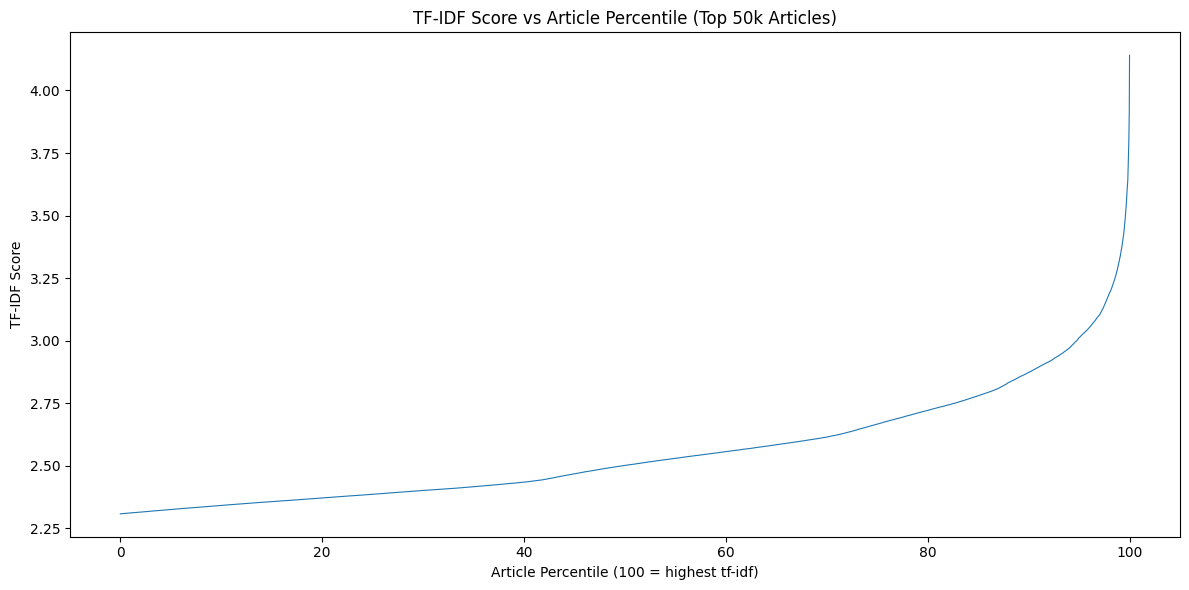

In [ ]:
print("reading df")
df_tf_idf = pd.read_csv(DATA_FOLDER / "tf_idf.csv", delimiter="@")
print("df created")
df_tf_idf.sort_values(by="tf-idf", ascending=False, inplace=True)
df_tf_idf = df_tf_idf.head(50000)
df_tf_idf.to_csv(DATA_FOLDER / "tf_idf_top_50000.csv", index=True, encoding='utf-8', sep=",")


# load the top-50000 tf-idf file
df_top = pd.read_csv(DATA_FOLDER / "tf_idf_top_50000.csv", sep=",", index_col=0)

# compute percentiles from 100 (highest tf-idf) down to 0
percentiles = np.linspace(100, 0, len(df_top))

plt.figure(figsize=(12, 6))
plt.plot(percentiles, df_top["tf-idf"], lw=0.8)
plt.xlabel("Article Percentile (100 = highest tf-idf)")
plt.ylabel("TF-IDF Score")
plt.title("TF-IDF Score vs Article Percentile (Top 50k Articles)")
plt.tight_layout()
plt.show()


In [15]:
# match the top 50000 csv with folder articles based on articleID (folder articles df) and article_id (df_top)
# extract the "text" and "title", "issueID" fields from the folder_articles, tf-idf field from df_top and use article id as the id
# put these to a single csv (text_of_top_articles.csv) with @ as delimiter

print("Load JSON articles into a DataFrame")
records = []
for json_file in TOKENIZED_DATA_FOLDER.glob("*.json"):
    with open(json_file, "r", encoding="utf-8") as f:
        issue = orjson.loads(f.read())
        for article in issue:
            records.append({
                "id": article.get("articleID"),
                "text": article.get("text"),
                "title": article.get("title"),
                "issueID": article.get("issueID")
            })
df_folder = pd.DataFrame.from_records(records)

# save the loaded folder articles to CSV with @ delimiter
output_path = DATA_FOLDER / "folder_articles.csv"
df_folder.to_csv(output_path, sep="@", index=False)
print(f"Saved folder articles CSV to {output_path.resolve()}")



Load JSON articles into a DataFrame


KeyboardInterrupt: 

In [22]:
print("Load TF–IDF top 50,000 CSV (index_col=0 gives the article_id index)")
df_top = pd.read_csv(DATA_FOLDER / "tf_idf_top_50000.csv", sep=",", index_col=0).set_index("Unnamed: 0", drop=True)
df_top.index.name = "id"
print(df_top.columns)
print(df_top.head(5))

df_folder = pd.read_csv(DATA_FOLDER / "folder_articles.csv", sep="@", index_col=0)
print(df_folder.columns)
print(df_folder.head(5))
df_folder.index.name = "id"

# 2. Merge on index=id
df_merged = df_folder.merge(
    df_top[["tf-idf"]],
    left_index=True,
    right_index=True,
    how="inner"
)

# apply punctuation removal to text
df_merged["text"] = df_merged["text"].map(clean_punct)
df_merged.sort_values(by="tf-idf", ascending=False, inplace=True)

# 3. Select and write out
df_output = df_merged[["text", "title", "issueID", "tf-idf"]]
df_output.to_csv(DATA_FOLDER / "text_of_top_articles.csv", sep="@")
print("Saved merged CSV to text_of_top_articles.csv")


Load TF–IDF top 50,000 CSV (index_col=0 gives the article_id index)
Index(['tea', 'cotton', 'coffe', 'sugar', 'rice', 'rubber', 'petroleum',
       'silk', 'tobacco', 'sisal',
       ...
       'YAZOO', 'YELLOWKNIFE', 'YELLOWSTONE', 'YOLA', 'YUKON',
       'YUKONTERRITORY', 'ZAMFARA', 'ZARIA', 'ZINGZINGBAR', 'tf-idf'],
      dtype='object', length=743)
                                            tea    cotton     coffe     sugar  \
id                                                                              
WO2_B0824STAREVAD_1791_03_07-0004-011  0.099859  0.228935  0.000000  0.000000   
WO2_B0756OBSERVER_1800_06_01-0002-003  0.085744  0.000000  0.197884  0.217782   
WO2_B0824STAREVAD_1791_04_04-0004-008  0.000000  0.145318  0.146286  0.160995   
WO2_B0438MOHEDAAD_1783_01_29-0001-003  0.000000  0.000000  0.000000  0.000000   
WO2_B0824STAREVAD_1791_01_22-0004-011  0.000000  0.108008  0.000000  0.239319   

                                           rice  rubber  petroleum     silk  

Finally, NER!

In [ ]:
import multiprocessing
import spacy

print("start")
nlp = spacy.load("en_core_web_sm")

# Read the CSV with custom separator
df = pd.read_csv(DATA_FOLDER / "text_of_top_articles.csv", sep='@')

def extract_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents]

texts = df['text'].astype(str)
total = len(texts)
entities = []

# Use spaCy’s built-in multiprocessing via n_process
for i, doc in enumerate(
        nlp.pipe(texts, batch_size=50, n_process=multiprocessing.cpu_count()),
        start=1
    ):
    entities.append(extract_entities(doc))
    print(f"Processed {i}/{total}", end="\r")

df['entities'] = entities

output_path = DATA_FOLDER / "articles_with_entities.csv"
df.to_csv(output_path, index=False)
print(f"\nDone — saved to {output_path}")


start


Then, we perform network analysis to visualize the results. 